<a href="https://colab.research.google.com/github/AlexKostjuk/dz_16/blob/master/dz_16_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
import xml.etree.ElementTree as ET
from transformers import T5Tokenizer, T5ForConditionalGeneration, MBartForConditionalGeneration, MBart50TokenizerFast
from transformers import pipeline
from google.colab import userdata
from huggingface_hub import login
import torch
import gc
from diffusers import StableDiffusionPipeline


In [38]:
from PIL import Image
from IPython.display import display

In [57]:
from diffusers import FluxPipeline


In [3]:
token = userdata.get("1_TOKEN")
login(token)

In [4]:
# Путь к файлу
fb2_path = "/content/drive/MyDrive/Avramenko.fb2"

# Загружаем XML с учетом пространства имен
tree = ET.parse(fb2_path)
root = tree.getroot()

# Указываем неймспейс из файла
namespace = {"fb2": "http://www.gribuser.ru/xml/fictionbook/2.0"}

# Ищем все главы (теги <section>)
sections = root.findall(".//fb2:section", namespace)

# Проверяем, нашлись ли главы
print(f"🔎 Найдено {len(sections)} глав(ы)")

# Список для хранения глав
book_contents = []

for section in sections:
    # # Извлекаем заголовок главы (если есть)
    # title = section.find("fb2:title", namespace)
    # chapter_title = "".join(title.itertext()).strip() if title is not None else "Без назви"

    # Извлекаем текст главы (все <p>)
    paragraphs = section.findall(".//fb2:p", namespace)
    chapter_text = "\n".join([p.text.strip() for p in paragraphs if p.text])

    # Добавляем главу в список
    book_contents.append(f"{chapter_text}")

🔎 Найдено 29 глав(ы)


In [5]:
# Выведем первые 1000 символов первой главы
if book_contents:
    print(book_contents[0][:1000])
else:
    print("❌ Главы не найдены.")

Пролог
…Резкие вскрикивания корабельной тревожной сирены, рвущие душу, привели его в чувство. Макс с трудом открыл глаза – залитая багровым аварийным светом изуродованная рубка, погасшие огни индикаторов и приборов… Сразу ноги запылали огнём, и человек с трудом перевёл отяжелевшие глаза вниз… Лучше бы не смотрел! Их попросту не было. Кровавое месиво там, где раньше находились его колени и всё, что ниже них. Даже вздрогнул от страха. Багровая лужа крови, растекающаяся под креслом, говорила сама за себя. Внезапно ему стало холодно. Понятно… Ощущая дикую боль, повернул голову влево, второй пилот сидел в своём кресле, но с первого взгляда стало ясно, что тот мёртв: да и кто может жить с громадной дырой на месте живота. Штурман? Попытался сфокусировать никак не желающие слушаться зрачки, однако, после второй попытки ему это удалось. Тот так же был мёртв. И – десятки дыр в стенах рубки, затянутые герметизирующей пеной, дрожащей под напором внутреннего давления. Вот почему он ещё жив! Похоже,

In [49]:
chapter_text = book_contents[0]

In [6]:
MODEL_NAME = 'cointegrated/rut5-base-absum'
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
model.cuda();
model.eval();

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/753 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/977M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/828k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [7]:
def summarize(
    text, n_words=None, compression=None,
    max_length=1000, num_beams=3, do_sample=False, repetition_penalty=10.0,
    **kwargs
):
    """
    Summarize the text
    The following parameters are mutually exclusive:
    - n_words (int) is an approximate number of words to generate.
    - compression (float) is an approximate length ratio of summary and original text.
    """
    if n_words:
        text = '[{}] '.format(n_words) + text
    elif compression:
        text = '[{0:.1g}] '.format(compression) + text
    x = tokenizer(text, return_tensors='pt', padding=True).to(model.device)
    with torch.inference_mode():
        out = model.generate(
            **x,
            max_length=max_length, num_beams=num_beams,
            do_sample=do_sample, repetition_penalty=repetition_penalty,
            **kwargs
        )
    return tokenizer.decode(out[0], skip_special_tokens=True)

In [50]:
print(summarize(chapter_text))

Сколько у меня времени?


In [20]:
tokenizer = T5Tokenizer.from_pretrained("cointegrated/rut5-base-multitask")
model = T5ForConditionalGeneration.from_pretrained("cointegrated/rut5-base-multitask")

tokenizer_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/828k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/977M [00:00<?, ?B/s]

In [27]:
def generate(text, **kwargs):
    inputs = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        hypotheses = model.generate(**inputs, num_beams=5, **kwargs)
    return tokenizer.decode(hypotheses[0], skip_special_tokens=True)

In [51]:
print(generate(f'simplify |{chapter_text}', max_length=500))

Направляй транспорт на планету, где находится мой дубликат. Посадить корабль в укромном месте


In [33]:
model_id = "stabilityai/stable-diffusion-2-1"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [52]:
prompt = "Направляй транспорт на планету, где находится мой дубликат. Посадить корабль в укромном месте"
image = pipe(prompt,num_inference_steps=50).images[0]


The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['абль в укромном месте']


  0%|          | 0/50 [00:00<?, ?it/s]

In [53]:
image.save("/content/drive/MyDrive/output3.png")

In [54]:
img = Image.open("/content/drive/MyDrive/output3.png")

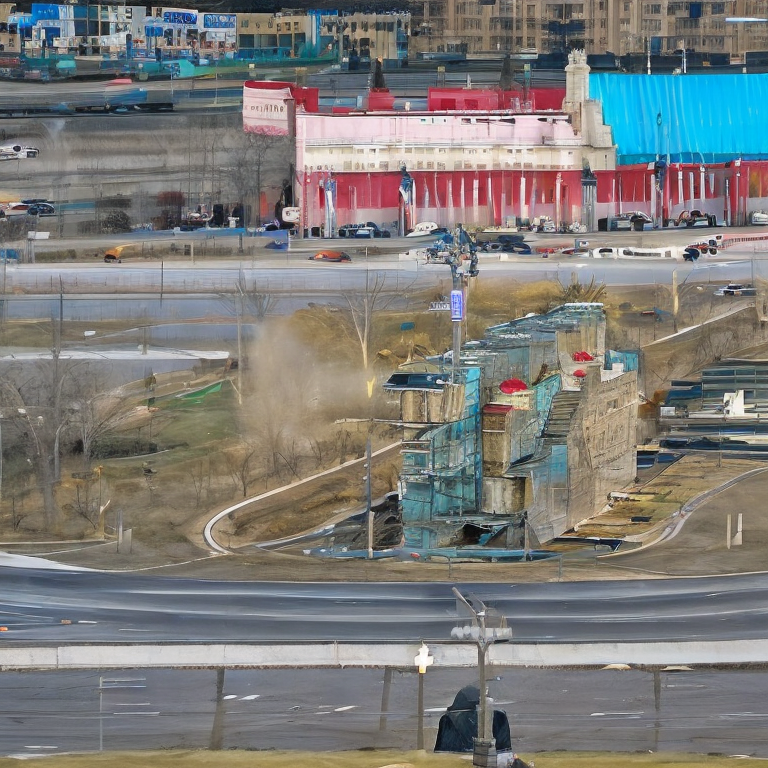

In [55]:
display(img)

In [58]:
pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-dev", torch_dtype=torch.bfloat16)
pipe.enable_sequential_cpu_offload()

model_index.json:   0%|          | 0.00/536 [00:00<?, ?B/s]

Fetching 23 files:   0%|          | 0/23 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.53G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/782 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

(…)pytorch_model-00001-of-00003.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/378 [00:00<?, ?B/s]

(…)pytorch_model-00002-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

(…)ion_pytorch_model.safetensors.index.json:   0%|          | 0.00/121k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/820 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

(…)pytorch_model-00003-of-00003.safetensors:   0%|          | 0.00/3.87G [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
prompt = "Направляй транспорт на планету, где находится мой дубликат. Посадить корабль в укромном месте"
image = pipe(
    prompt,
    height=512,
    width=512,
    guidance_scale=3.5,
    num_inference_steps=20,
    max_sequence_length=512,
    generator=torch.Generator("cpu").manual_seed(0)
).images[0]
image.save("/content/drive/MyDrive/flux-dev1.png")

Token indices sequence length is longer than the specified maximum sequence length for this model (98 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['абль в укромном месте']


  0%|          | 0/20 [00:00<?, ?it/s]